In [1]:
import pandas as pd
import numpy as np
import time

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import common.common_machine_learning as common
import common.feature_num as feature_num
import common.features_precio_promedio_metroscubiertos as feature_metroscubiertos
import common.features_precio_promedio_ciudad as feature_ciudades

In [2]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [3]:
TARGET = "precio"
MAX_ITER = 10

In [4]:
def limpiar(df):
    df.antiguedad = df.antiguedad.fillna(df.antiguedad.mean())
    df.metroscubiertos = df.metroscubiertos.fillna(df.metroscubiertos.mean())
    df.habitaciones = df.habitaciones.fillna(df.habitaciones.mean())
    df.garages = df.garages.fillna(0)
    df.banos = df.banos.fillna(1)
    df.tipodepropiedad = df.tipodepropiedad.fillna('Casa')
    df.metroscubiertos = df.metroscubiertos.fillna(df.metroscubiertos.mean())
    df.metrostotales = df.metrostotales.fillna(df.metrostotales.mean())
    df.gimnasio = df.gimnasio.fillna(0)
    df.usosmultiples = df.usosmultiples.fillna(0)
    df.piscina = df.piscina.fillna(0)
    df.escuelascercanas = df.escuelascercanas.fillna(0)
    df.centroscomercialescercanos = df.centroscomercialescercanos.fillna(0)
    df["metroscubiertos"] = df["metroscubiertos"].fillna(df["metroscubiertos"].mean())
    df.fillna(value = {"tipodepropiedad" : df["tipodepropiedad"].mode().to_string(),
                        "provincia" : df["provincia"].mode().to_string(),
                        "ciudad": df["ciudad"].mode().to_string()}, inplace = True)
    
def evaluar_rf(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    errors = abs(y_pred - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Performance del modelo:')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

### Cargo los datos

In [5]:
train = pd.read_csv('sets_de_datos/train.csv', index_col = 0)
test = pd.read_csv('sets_de_datos/test.csv', index_col = 0)

### Limpio el dataset

In [6]:
limpiar(train)
limpiar(test)

In [7]:
train["provincia"].replace(["", np.nan], [train["provincia"].mode(), train["provincia"].mode()], inplace=True)
test["provincia"].replace(["", np.nan], [test["provincia"].mode(), test["provincia"].mode()], inplace=True)

train['provincia'] = train['provincia'].str.replace("0    Distrito Federal","Distrito Federal")
test['provincia'] = test['provincia'].str.replace("0    Distrito Federal","Distrito Federal")

In [8]:
test['tipodepropiedad'] = test['tipodepropiedad'].str.replace('0    Casa',"Casa")

In [9]:
train = feature_num.completar_lat_lng_con_provincias_y_ciudades(train)
train = feature_num.completar_lat_lng_con_idzona_mean(train)
feature_num.completar_lat_lng_con_promedio_Mexico(train)

In [10]:
test = feature_num.completar_lat_lng_con_provincias_y_ciudades(test)
test = feature_num.completar_lat_lng_con_idzona_mean(test)
feature_num.completar_lat_lng_con_promedio_Mexico(test)

In [11]:
train.isna().sum()

titulo                         5387
descripcion                    1619
tipodepropiedad                   0
direccion                     53072
ciudad                            0
provincia                         0
antiguedad                        0
habitaciones                      0
garages                           0
banos                             0
metroscubiertos                   0
metrostotales                     0
idzona                        28621
lat                               0
lng                               0
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
precio                            0
dtype: int64

In [12]:
test.isna().sum()

titulo                         1378
descripcion                     401
tipodepropiedad                   0
direccion                     13191
ciudad                            0
provincia                         0
antiguedad                        0
habitaciones                      0
garages                           0
banos                             0
metroscubiertos                   0
metrostotales                     0
idzona                         7179
lat                               0
lng                               0
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
dtype: int64

In [13]:
mega_set = train.drop(['precio'], axis = 1).append(test, ignore_index = True)

In [14]:
mega_set.isna().sum()

titulo                         6765
descripcion                    2020
tipodepropiedad                   0
direccion                     66263
ciudad                            0
provincia                         0
antiguedad                        0
habitaciones                      0
garages                           0
banos                             0
metroscubiertos                   0
metrostotales                     0
idzona                        35800
lat                               0
lng                               0
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
dtype: int64

In [15]:
train.to_csv("sets_de_datos/train_limpio.csv",index=True)

In [16]:
test.to_csv("sets_de_datos/test_limpio.csv",index=True)

In [17]:
train_limpio = pd.read_csv('sets_de_datos/train_limpio.csv', index_col = 0)

# Agrego features!

### Servicios_cercanos

In [18]:
mega_set['servicios_cercanos'] = mega_set['escuelascercanas'].astype(int)  + mega_set['centroscomercialescercanos'].astype(int)
train['servicios_cercanos'] = train['escuelascercanas'].astype(int)  + train['centroscomercialescercanos'].astype(int)
test['servicios_cercanos'] = test['escuelascercanas'].astype(int)  + test['centroscomercialescercanos'].astype(int)

### utilidades_extra

In [19]:
mega_set['utilidades_extra'] =\
  mega_set['gimnasio'].astype(int) + mega_set['usosmultiples'].astype(int) + mega_set['piscina'].astype(int)
train['utilidades_extra'] =\
  train['gimnasio'].astype(int) + train['usosmultiples'].astype(int) + train['piscina'].astype(int)
test['utilidades_extra'] =\
  test['gimnasio'].astype(int) + test['usosmultiples'].astype(int) + test['piscina'].astype(int)

In [20]:
out = mega_set.copy()
for col  in ['tipodepropiedad', 'ciudad', 'provincia']:
  for sub_col in ['antiguedad', 'habitaciones', 'garages', 'banos', 
                  'metroscubiertos', 'utilidades_extra', 'servicios_cercanos']:
    sub_col_mean_x_col =\
      mega_set.groupby([col]).agg({sub_col : 'mean'}).to_dict()
    
    out[col + '_mean_' + sub_col] =\
      out.apply(lambda x: sub_col_mean_x_col[sub_col].get(x[col], np.nan), 
                axis = 1)
mega_set = out.copy()

In [21]:
out = train.copy()
for col  in ['tipodepropiedad', 'ciudad', 'provincia']:
  for sub_col in ['antiguedad', 'habitaciones', 'garages', 'banos', 
                  'metroscubiertos', 'utilidades_extra', 'servicios_cercanos']:
    sub_col_mean_x_col =\
      mega_set.groupby([col]).agg({sub_col : 'mean'}).to_dict()
    
    out[col + '_mean_' + sub_col] =\
      out.apply(lambda x: sub_col_mean_x_col[sub_col].get(x[col], np.nan), 
                axis = 1)
train = out.copy()

In [22]:
out = test.copy()
for col  in ['tipodepropiedad', 'ciudad', 'provincia']:
  for sub_col in ['antiguedad', 'habitaciones', 'garages', 'banos', 
                  'metroscubiertos', 'utilidades_extra', 'servicios_cercanos']:
    sub_col_mean_x_col =\
      mega_set.groupby([col]).agg({sub_col : 'mean'}).to_dict()
    
    out[col + '_mean_' + sub_col] =\
      out.apply(lambda x: sub_col_mean_x_col[sub_col].get(x[col], np.nan), 
                axis = 1)
test = out.copy()

### provincia_mean_lat y ciudad_mean_lat

In [23]:
out = mega_set.copy()
lat_lng_mean_x_ciudad_x_provincia =\
  mega_set.groupby(['provincia', 'ciudad'])\
    .agg({'lat' : 'mean', 'lng' : 'mean'}).to_dict()

out['ciudad_mean_lat'] =\
  out.apply(lambda x: lat_lng_mean_x_ciudad_x_provincia['lat']\
                        .get((x['provincia'], x['ciudad']), np.nan), axis = 1)

out['ciudad_mean_lng'] =\
  out.apply(lambda x: lat_lng_mean_x_ciudad_x_provincia['lng']\
                        .get((x['provincia'], x['ciudad']), np.nan), axis = 1)
lat_lng_mean_x_provincia =\
  mega_set.groupby(['provincia'])\
      .agg({'lat' : 'mean', 'lng' : 'mean'}).to_dict()

out['provincia_mean_lat'] =\
  out.apply(lambda x: lat_lng_mean_x_provincia['lat']\
                        .get(x['provincia'], np.nan), axis = 1)
  
out['provincia_mean_lng'] =\
  out.apply(lambda x: lat_lng_mean_x_provincia['lng']\
                        .get(x['provincia'], np.nan), axis = 1)
mega_set = out.copy()

In [24]:
out = train.copy()
lat_lng_mean_x_ciudad_x_provincia =\
  mega_set.groupby(['provincia', 'ciudad'])\
    .agg({'lat' : 'mean', 'lng' : 'mean'}).to_dict()

out['ciudad_mean_lat'] =\
  out.apply(lambda x: lat_lng_mean_x_ciudad_x_provincia['lat']\
                        .get((x['provincia'], x['ciudad']), np.nan), axis = 1)

out['ciudad_mean_lng'] =\
  out.apply(lambda x: lat_lng_mean_x_ciudad_x_provincia['lng']\
                        .get((x['provincia'], x['ciudad']), np.nan), axis = 1)
lat_lng_mean_x_provincia =\
  mega_set.groupby(['provincia'])\
      .agg({'lat' : 'mean', 'lng' : 'mean'}).to_dict()

out['provincia_mean_lat'] =\
  out.apply(lambda x: lat_lng_mean_x_provincia['lat']\
                        .get(x['provincia'], np.nan), axis = 1)
  
out['provincia_mean_lng'] =\
  out.apply(lambda x: lat_lng_mean_x_provincia['lng']\
                        .get(x['provincia'], np.nan), axis = 1)
train = out.copy()

In [25]:
out = test.copy()
lat_lng_mean_x_ciudad_x_provincia =\
  mega_set.groupby(['provincia', 'ciudad'])\
    .agg({'lat' : 'mean', 'lng' : 'mean'}).to_dict()

out['ciudad_mean_lat'] =\
  out.apply(lambda x: lat_lng_mean_x_ciudad_x_provincia['lat']\
                        .get((x['provincia'], x['ciudad']), np.nan), axis = 1)

out['ciudad_mean_lng'] =\
  out.apply(lambda x: lat_lng_mean_x_ciudad_x_provincia['lng']\
                        .get((x['provincia'], x['ciudad']), np.nan), axis = 1)
lat_lng_mean_x_provincia =\
  mega_set.groupby(['provincia'])\
      .agg({'lat' : 'mean', 'lng' : 'mean'}).to_dict()

out['provincia_mean_lat'] =\
  out.apply(lambda x: lat_lng_mean_x_provincia['lat']\
                        .get(x['provincia'], np.nan), axis = 1)
  
out['provincia_mean_lng'] =\
  out.apply(lambda x: lat_lng_mean_x_provincia['lng']\
                        .get(x['provincia'], np.nan), axis = 1)
test = out.copy()

### Distancia angular al centro de la ciudad/provincia/pais

In [26]:
out = mega_set.copy()
out['coseno_distancia_angular_al_centro_ciudad'] = out.apply(lambda x: x['lat']*x['ciudad_mean_lat'] + x['lng']*x['ciudad_mean_lng'], axis =1)  
out['coseno_distancia_angular_al_centro_provincia'] = out.apply(lambda x: x['lat']*x['provincia_mean_lat'] + x['lng']*x['provincia_mean_lng'], axis = 1) 
out['coseno_distancia_angular_al_centro_pais'] = out.apply(lambda x: x['lat']*23.062283 + x['lng']*-109.699951, axis = 1)
mega_set = out.copy()

In [27]:
out = train.copy()
out['coseno_distancia_angular_al_centro_ciudad'] = out.apply(lambda x: x['lat']*x['ciudad_mean_lat'] + x['lng']*x['ciudad_mean_lng'], axis =1)  
out['coseno_distancia_angular_al_centro_provincia'] = out.apply(lambda x: x['lat']*x['provincia_mean_lat'] + x['lng']*x['provincia_mean_lng'], axis = 1) 
out['coseno_distancia_angular_al_centro_pais'] = out.apply(lambda x: x['lat']*23.062283 + x['lng']*-109.699951, axis = 1)
train = out.copy()

In [28]:
out = test.copy()
out['coseno_distancia_angular_al_centro_ciudad'] = out.apply(lambda x: x['lat']*x['ciudad_mean_lat'] + x['lng']*x['ciudad_mean_lng'], axis =1)  
out['coseno_distancia_angular_al_centro_provincia'] = out.apply(lambda x: x['lat']*x['provincia_mean_lat'] + x['lng']*x['provincia_mean_lng'], axis = 1) 
out['coseno_distancia_angular_al_centro_pais'] = out.apply(lambda x: x['lat']*23.062283 + x['lng']*-109.699951, axis = 1)
test = out.copy()

### Features de metros cubiertos y totales (y sus relaciones)

In [29]:
def metros_no_cubiertos(m_totales, m_cubiertos):
    if m_cubiertos >= m_totales:
        return 0
    return m_totales - m_cubiertos
    

mega_set['metros_no_cubiertos'] =\
    mega_set.apply(lambda x: metros_no_cubiertos(x['metrostotales'], x['metroscubiertos']), axis = 1)
train['metros_no_cubiertos'] =\
    train.apply(lambda x: metros_no_cubiertos(x['metrostotales'], x['metroscubiertos']), axis = 1)
test['metros_no_cubiertos'] =\
    test.apply(lambda x: metros_no_cubiertos(x['metrostotales'], x['metroscubiertos']), axis = 1)

In [30]:
def cantidad_espacios(df):
    cantidad_espacios = 0
    for col in ['habitaciones', 'garages', 'banos', 'gimnasio', 'usosmultiples', 'piscina']:
        cantidad_espacios += int(df[col])
    return cantidad_espacios

mega_set['cantidad_espacios'] = mega_set.apply(cantidad_espacios, axis = 1)
train['cantidad_espacios'] = train.apply(cantidad_espacios, axis = 1)
test['cantidad_espacios'] = test.apply(cantidad_espacios, axis = 1)

In [31]:
def metros_x_espacio(cantidad_espacios, metros_cubiertos):
    if cantidad_espacios <= 0 or metros_cubiertos <= 0:
        return 0
    return metros_cubiertos / cantidad_espacios

mega_set['metros_x_espacio'] =\
  mega_set.apply(lambda x: metros_x_espacio(x['cantidad_espacios'], x['metroscubiertos']), axis = 1)
train['metros_x_espacio'] =\
  train.apply(lambda x: metros_x_espacio(x['cantidad_espacios'], x['metroscubiertos']), axis = 1)
test['metros_x_espacio'] =\
  test.apply(lambda x: metros_x_espacio(x['cantidad_espacios'], x['metroscubiertos']), axis = 1)

In [32]:
def metros_en_varios_espacios(repeticiones_espacio, metros_x_espacio):
    if repeticiones_espacio <= 0 or metros_x_espacio <= 0:
        return 0
    return repeticiones_espacio * metros_x_espacio

for col in ['habitaciones', 'garages', 'banos', 'utilidades_extra']:
    mega_set['metros_x_' + col] =\
        mega_set.apply(lambda x: metros_en_varios_espacios(x[col], x['metros_x_espacio']), axis = 1)
for col in ['habitaciones', 'garages', 'banos', 'utilidades_extra']:
    train['metros_x_' + col] =\
        train.apply(lambda x: metros_en_varios_espacios(x[col], x['metros_x_espacio']), axis = 1)
for col in ['habitaciones', 'garages', 'banos', 'utilidades_extra']:
    test['metros_x_' + col] =\
        test.apply(lambda x: metros_en_varios_espacios(x[col], x['metros_x_espacio']), axis = 1)

In [33]:
mega_set['ratio_metros_cubiertos'] = mega_set['metroscubiertos'] / mega_set['metrostotales']
mega_set['ratio_metros_cubiertos'] = mega_set['ratio_metros_cubiertos'].transform(lambda x: x if x < 1 else 1)
mega_set['ratio_metros_cubiertos'] = mega_set['ratio_metros_cubiertos'].transform(lambda x: x if x > 0 else 0)

In [34]:
train['ratio_metros_cubiertos'] = train['metroscubiertos'] / mega_set['metrostotales']
train['ratio_metros_cubiertos'] = train['ratio_metros_cubiertos'].transform(lambda x: x if x < 1 else 1)
train['ratio_metros_cubiertos'] = train['ratio_metros_cubiertos'].transform(lambda x: x if x > 0 else 0)

In [35]:
test['ratio_metros_cubiertos'] = test['metroscubiertos'] / mega_set['metrostotales']
test['ratio_metros_cubiertos'] = test['ratio_metros_cubiertos'].transform(lambda x: x if x < 1 else 1)
test['ratio_metros_cubiertos'] = test['ratio_metros_cubiertos'].transform(lambda x: x if x > 0 else 0)

### Precio promedio de según cantidad de banos/habitaciones/garages por ciudad

In [36]:
train = feature_ciudades.asignar_precio_promedio_por_cantidad_de_banos_por_ciudad(train)

In [37]:
train = feature_ciudades.asignar_precio_promedio_por_cantidad_de_habitaciones_por_ciudad(train)

In [38]:
train = feature_ciudades.asignar_precio_promedio_por_cantidad_de_garages_por_ciudad(train)

In [39]:
test = feature_ciudades.asignar_precio_promedio_por_cantidad_de_banos_por_ciudad(test)

In [40]:
test = feature_ciudades.asignar_precio_promedio_por_cantidad_de_habitaciones_por_ciudad(test)

In [41]:
test = feature_ciudades.asignar_precio_promedio_por_cantidad_de_garages_por_ciudad(test)

### Precio promedio según la cantidad de banos/habitaciones/garages por metroscubiertos

In [42]:
train = feature_metroscubiertos.agregar_feature_precio_promedio_banos_por_metroscubiertos(train)

In [43]:
train = feature_metroscubiertos.agregar_feature_precio_promedio_habitaciones_por_metroscubiertos(train)

In [44]:
train = feature_metroscubiertos.agregar_feature_precio_promedio_garages_por_metroscubiertos(train)

In [45]:
test = feature_metroscubiertos.agregar_feature_precio_promedio_banos_por_metroscubiertos(test)

In [46]:
test = feature_metroscubiertos.agregar_feature_precio_promedio_habitaciones_por_metroscubiertos(test)

In [47]:
test = feature_metroscubiertos.agregar_feature_precio_promedio_garages_por_metroscubiertos(test)

### Promedio de banos/habitaciones/garages, precio por metro cuadrado y promedio del precio por tipodepropiedad

In [48]:
def nuevas_features(df, precios_tipo,precio_m2,promedios,default_m2):
    df['mean_tipodepropiedad'] = df['tipodepropiedad'].apply(lambda x: precios_tipo.loc[x]['precio_por_tipo'])
    df['precio_x_m2'] = df.apply(lambda x: precio_x_m2.get(x['ciudad'],default_m2), axis = 1)
    df['mean_hab'] = df.apply(lambda x: promedios['mean_hab'].get(x['ciudad'],default_m2), axis = 1)
    df['mean_ban'] = df.apply(lambda x: promedios['mean_ban'].get(x['ciudad'],default_m2), axis = 1)
    df['mean_gar'] = df.apply(lambda x: promedios['mean_gar'].get(x['ciudad'],default_m2), axis = 1)

df_precios_por_tipo = train.groupby('tipodepropiedad').agg({'precio':'mean'}).rename(columns={'precio':'precio_por_tipo'})
train['precio_x_m2'] = train['precio']/train['metroscubiertos']
precio_x_m2 = train.groupby('ciudad').agg({'precio_x_m2':'mean'}).to_dict()['precio_x_m2']
default = train.groupby('ciudad').agg({'precio_x_m2':'mean'})['precio_x_m2'].mean()
promedios = train.set_index('ciudad')\
            .join(train.groupby('ciudad')\
                  .agg({'habitaciones':'mean', 'garages':'mean', 'banos':'mean'})\
                      .rename(columns={'habitaciones':'mean_hab', 'banos':'mean_ban', 'garages':'mean_gar'}))\
                        [['mean_hab','mean_gar','mean_ban']].to_dict()
nuevas_features(train, df_precios_por_tipo, precio_x_m2,promedios,default)
nuevas_features(test, df_precios_por_tipo, precio_x_m2,promedios,default)

In [49]:
test

,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,...,habitaciones_preciopromedio_ciudad,garages_preciopromedio_ciudad,banos_preciopromedio_metroscubiertos,habitaciones_preciopromedio_metroscubiertos,garages_preciopromedio_metroscubiertos,mean_tipodepropiedad,precio_x_m2,mean_hab,mean_ban,mean_gar
id,,,,,,,,,,,,,,,,,,,,,
4941,"casa en venta en miguel hidalgo, distrito federal",<p>excelente casa estilo moderno.</p>,Casa,Bosque de Cedros,Miguel Hidalgo,Distrito Federal,29.000000,3.000000,0.0,4.0,...,5.744953e+06,4.064390e+06,4.618752e+06,4.711819e+06,4.532073e+06,2.398110e+06,31531.187667,2.508828,1.866091,1.303192
51775,departamentos en venta en montebello,<p>departamento una recamara:\n</p><p>departam...,Apartamento,NaN,Mérida,Yucatán,8.152599,1.000000,1.0,1.0,...,1.256968e+06,1.035800e+06,9.033689e+05,1.845488e+06,1.001276e+06,2.763769e+06,9622.658660,2.928739,2.425859,1.357163
115253,departamento nuevo delegación coyoacán de 87 m...,"departamento nuevo de 87.06 m2, 1 cajón de est...",Apartamento,"Pueblo de los Reyes, Coyoacán, Mexico D.F.",Coyoacán,Distrito Federal,0.000000,2.000000,1.0,2.0,...,1.870455e+06,1.820429e+06,1.591238e+06,1.071041e+06,1.001276e+06,2.763769e+06,20496.700434,3.025226,1.979029,1.336671
299321,departamento en venta en acapulco,<p> raíces dv001 precioso departamento tipo k...,Apartamento,NaN,Acapulco de Juárez,Guerrero,2.000000,2.000000,2.0,2.0,...,1.374582e+06,3.692571e+06,1.591238e+06,1.071041e+06,1.370549e+06,2.763769e+06,15431.914345,2.823817,2.198452,1.224531
173570,bonita casa sola equipada de dos niveles en lo...,"<p>casa sola, bonita de dos rec&aacute;maras u...",Casa,CEDROS,Tultitlán,Edo. de México,10.000000,2.000000,1.0,1.0,...,5.649999e+05,6.191019e+05,9.033689e+05,1.071041e+06,1.001276e+06,2.398110e+06,8691.958285,2.799797,1.340136,1.073858
30862,casa en venta parques de santa maria 3rec. por...,a un costado de parques de santa maría \ncon ...,Casa,Fresno 2601,Zapopan,Jalisco,10.000000,3.000000,1.0,2.0,...,2.903993e+06,1.055876e+06,2.375798e+06,2.647100e+06,1.941647e+06,2.398110e+06,14812.647290,3.002699,2.195270,1.439479
244471,casa en venta en la col. cortijo del rio,"<p>excelente propiedad en zona sur, cocina amp...",Casa,SENDA DE LA CREACIÓN,Monterrey,Nuevo León,20.000000,3.000000,0.0,2.0,...,3.314399e+06,3.003517e+06,2.782664e+06,3.107114e+06,2.954647e+06,2.398110e+06,14674.329607,3.043701,2.324791,1.234955
127794,"casas javer, casas de 3 recamaras. a tan solo ...",bosques de lerma es un exclusivo fraccionamien...,Casa,lerma estado de mexico,Lerma,Edo. de México,0.000000,2.000000,1.0,1.0,...,1.097721e+06,7.726791e+05,9.033689e+05,1.071041e+06,1.001276e+06,2.398110e+06,13162.184822,2.778518,1.871460,1.270153
71558,hermosa casa con alberca y acceso a la playa,"hermosa residencia, con alberca y acceso a la ...",Casa,Americas 2,Veracruz,Veracruz,2.000000,3.000000,2.0,2.0,...,1.434458e+06,1.495640e+06,3.316645e+06,3.966369e+06,3.540276e+06,2.398110e+06,9499.002798,2.826529,1.823136,1.008604


In [50]:
train.to_csv("sets_de_datos/train_con_features.csv", index=True)
test.to_csv("sets_de_datos/test_con_features.csv", index=True)

# Importancia de las features

In [51]:
drop_cols = ['titulo', 'descripcion', 'direccion', 'idzona', "fecha"]

muestra = train.sample(frac = 0.25, random_state = 1)
muestra = muestra.drop(drop_cols, axis=1).copy()
muestra = muestra.sample(frac = 0.25, random_state = 1)

In [52]:
cat_features = ['tipodepropiedad', 'provincia', 'ciudad']

label_encoder = LabelEncoder()

for cat in cat_features:
    muestra = muestra.fillna(value = {cat : 'NaN'})
    muestra[cat] = label_encoder.fit_transform(muestra[cat])    

In [53]:
muestra_X = muestra.drop([TARGET], axis=1)
muestra_y = muestra[TARGET]

## f_classif

In [54]:
selector = SelectKBest(f_classif, k=3)
muestra_X_new = selector.fit_transform(muestra_X, muestra_y)

In [55]:
feature_cols = muestra.columns.drop(TARGET)

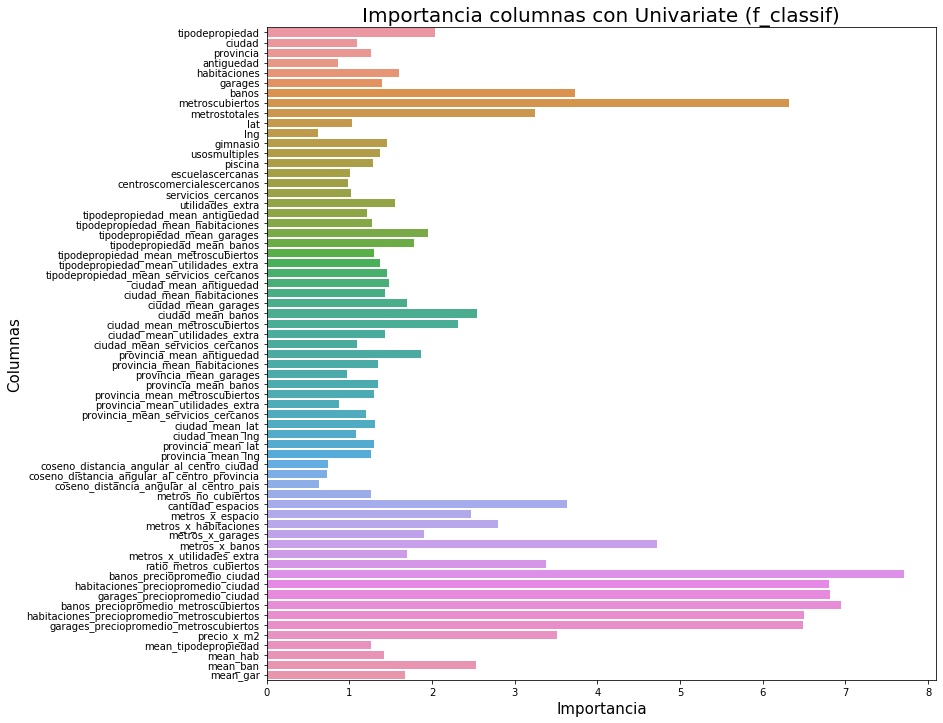

In [56]:
plot = sns.barplot(
            x = selector.scores_,
            y = feature_cols
        )

plot.set_xlabel('Importancia', fontsize = 15)
plot.set_ylabel('Columnas', fontsize = 15)
plot.set_title('Importancia columnas con Univariate (f_classif)', fontsize = 20)
fig = plot.get_figure()
fig.set_size_inches(12,12)

#plot.set_xticklabels(plot.get_xticklabels(), rotation = 90)
plt.show()

## mutual_info_classif

In [57]:
selector_mutual = SelectKBest(mutual_info_classif, k=3)

muestra_X_new = selector_mutual.fit_transform(muestra_X, muestra_y)

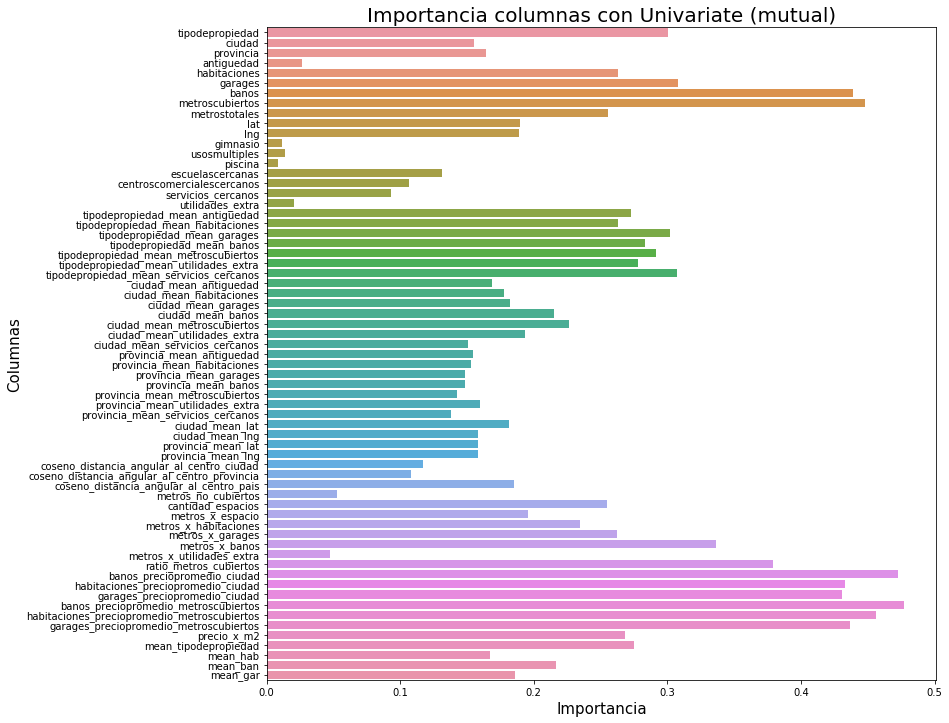

In [58]:
plot = sns.barplot(
            y = feature_cols,
            x = selector_mutual.scores_,
        )

plot.set_xlabel('Importancia', fontsize = 15)
plot.set_ylabel('Columnas', fontsize = 15)
plot.set_title('Importancia columnas con Univariate (mutual)', fontsize = 20)
fig = plot.get_figure()
fig.set_size_inches(12,12)

plt.show()

## Random Forest

In [59]:
forest_model = RandomForestRegressor(n_estimators=10, random_state=1)
forest_model.fit(muestra_X, muestra_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

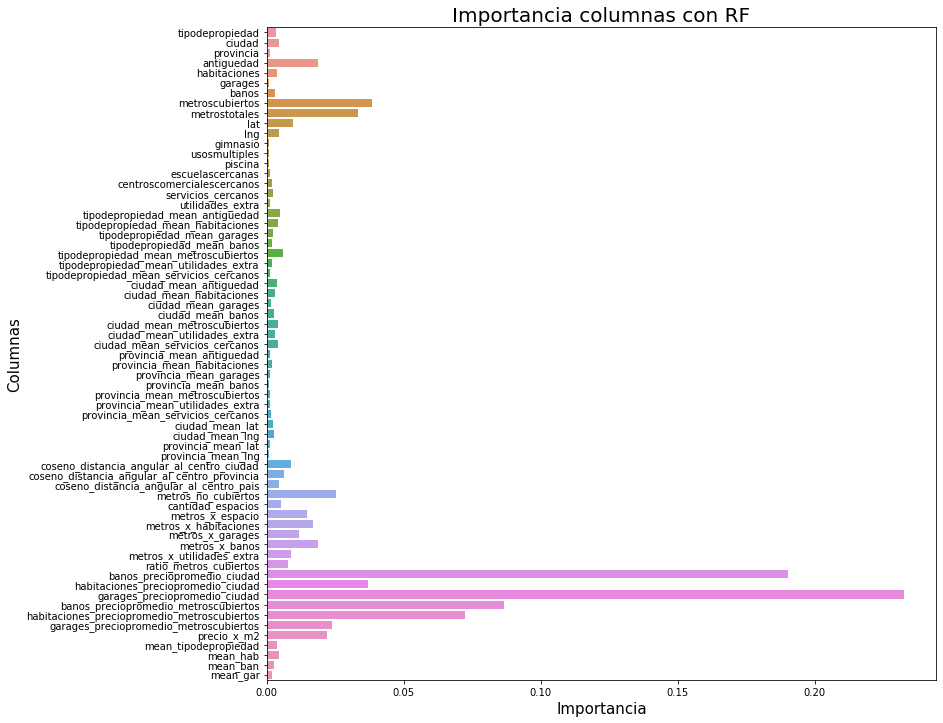

In [60]:
plot = sns.barplot(
            y = feature_cols,
            x = forest_model.feature_importances_,
        )

plot.set_xlabel('Importancia', fontsize = 15)
plot.set_ylabel('Columnas', fontsize = 15)
plot.set_title('Importancia columnas con RF', fontsize = 20)
fig = plot.get_figure()
fig.set_size_inches(12,12)

plt.show()